# Capstone Project Part 2: Trending YouTube Video Statistics

YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”.This dataset is a daily record of the top trending YouTube videos.

This dataset GBvideos.csv is taken from https://www.kaggle.com/datasnaek/youtube-new/home and is specific to Great Britain. There is also a json file, GB_category_id, read in this notebook which holds the category information for the videos.  In this assignment I have tried to uderstand a few trending video statistics and also applied some machine learning which I learned.



In [157]:
import pandas as pd
import numpy as np
from datetime import datetime 
from math import pi

import json

from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
import matplotlib.pyplot as plt

import textmining as tm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from IPython.display import YouTubeVideo

In [158]:
output_notebook()

Loading BokehJS ...

In [159]:
#First let us read the data for Great Britain.

gb_vdo_df = pd.DataFrame(pd.read_csv('GBvideos.csv'))
gb_vdo_df.head(3)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...


## 1. General Information on the Dataset

### Find the time period the data was collected

In [160]:
#Get the minimum and max date
Min_date = gb_vdo_df['trending_date'].min()
Max_date = gb_vdo_df['trending_date'].max()

#Convert the date string to date(using strptime) and then convert to requried format (using strftime)
Min_date_MY = datetime.strptime(Min_date,'%y.%d.%m').strftime('%B %Y')
Max_date_MY = datetime.strptime(Max_date,'%y.%d.%m').strftime('%B %Y')
'The data is collected for trending videos from {min} till {max}'.format(min= Min_date_MY, max= Max_date_MY)

'The data is collected for trending videos from December 2017 till May 2018'

### Verify for null values

In [161]:
gb_vdo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null object
title                     38916 non-null object
channel_title             38916 non-null object
category_id               38916 non-null int64
publish_time              38916 non-null object
tags                      38916 non-null object
views                     38916 non-null int64
likes                     38916 non-null int64
dislikes                  38916 non-null int64
comment_count             38916 non-null int64
thumbnail_link            38916 non-null object
comments_disabled         38916 non-null bool
ratings_disabled          38916 non-null bool
video_error_or_removed    38916 non-null bool
description               38304 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.0+ MB


**The data is mostly clean. All fields except description have got values. There are 16 columns and 38916 records. There are 2 columns that has date value in it, but is of type 'object'.**

In [162]:
# Lets convert the columns 'trending_date' and 'publish_time' to date type.
gb_vdo_df['trending_date'] = pd.to_datetime(gb_vdo_df['trending_date'],format="%y.%d.%m")
gb_vdo_df['publish_time']= pd.to_datetime(gb_vdo_df['publish_time'])

### Video Categories

**The dataset also contains the category id  of the videos. The category names are present in the associated json file.By mapping the category id to the name,we can investigate which categories has got the trending videos. For that we need to read the json file first.The category name is then mapped to column 'category_id_d' in gb_vdo_df**

In [163]:
category_file = json.loads(open('GB_category_id.json').read())

#Initialise id_dict dictionary 
cat_dict = {}

#Extract id and title from 'items' block
for category in category_file['items']:
        cat_dict[int(category['id'])] = category['snippet']['title']

#Map category id to title and assign to a new column in gb_vdo_df 
gb_vdo_df['category_id_d'] = gb_vdo_df['category_id'].map(cat_dict)


### 2. Statistics on Video Categories

**Let us categorise the videos and see which categories has got the most trending videos.**

In [164]:
gb_vdo_cat = gb_vdo_df.groupby('category_id_d')['video_id'].count().reset_index(name = 'count')
gb_vdo_cat['angle'] = gb_vdo_cat['count']/gb_vdo_cat['count'].sum() * 2*pi
gb_vdo_cat['color'] = Category20c[gb_vdo_cat.shape[0]]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
           tools="hover", tooltips="@category_id_d: @count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='category_id_d', source=gb_vdo_cat)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

**Music category has got the most trending videos followedby Entertainment.
The lowest number of videos belong to categories Autos&Vehicles and Travel&Events.**

### 3.Relation between views and  likes & dislike 

**Next we will see if there is a relation between views, likes and dislikes count of a video.**

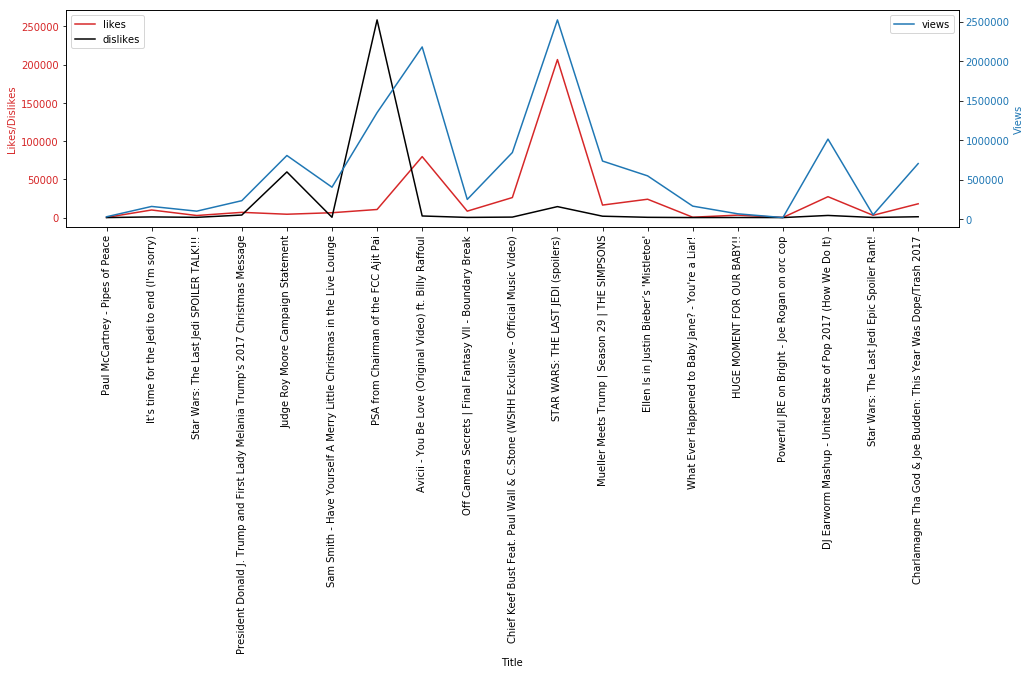

In [165]:
# Sort the videos by 'trending date' in descending order and  then group by video_id. 
#The first record in each group will have the latest trending date for a video_id.
gb_vdo = gb_vdo_df.sort_values(['trending_date'], ascending = False).groupby('video_id').first()

#To narrow the data, we will look at the videos for a specific date
gb_vdo_stat = gb_vdo[gb_vdo['trending_date']== '2018-01-02']


#t = gb_vdo_stat['channel_title']
t = gb_vdo_stat['title']
data1 = gb_vdo_stat['likes']
data2 = gb_vdo_stat['views']
data3 = gb_vdo_stat['dislikes']

fig, ax1 = plt.subplots(figsize = (16,4))

color = 'tab:red'
#ax1.set_xlabel('Channel Title')
ax1.set_xlabel('Title')
ax1.set_ylabel('Likes/Dislikes', color=color)
ax1.plot(t, data1, color=color)
ax1.plot(t, data3, color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.legend(loc=2)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Views', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=1)

plt.show()


* Both y-axis are on different scales

**Mostly, 'likes' count for trending videos are more than 'dislikes', but there are videos where dislike count is more. Once a video makes to the trending list, more people will start watching and might dislike it..For e.g. "PSA from chairman of the FCC Ajit Pai..", the dislike count is far more than likes and the video has been trending!!!!!**

## 4. Top videos on the chart

 **Now lets look at the videos that have topped the list for the highest views, likes, dislikes,comments.**

Video with highest views 424538912 .


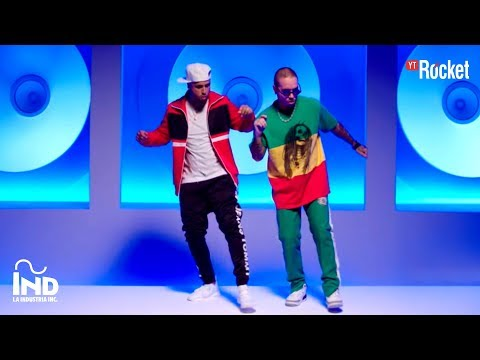

In [166]:
# We can use the gb_vdo df to find it.

gb_vdo_topv = gb_vdo.sort_values(by = 'views', ascending = False).reset_index()
#gb_vdo_topv
print("Video with highest views",gb_vdo_topv.iloc[0]["views"],".")
YouTubeVideo(gb_vdo_topv.iloc[0]["video_id"])

Trending video with highest likes 5613827 .


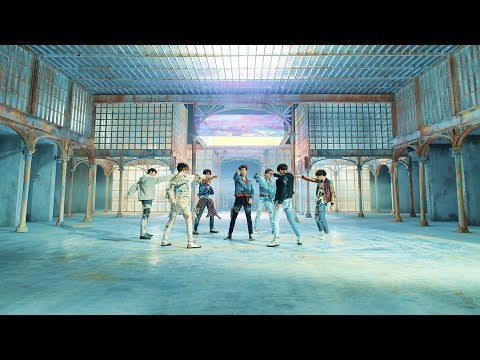

In [167]:
gb_vdo_topl = gb_vdo.sort_values(by = 'likes', ascending = False).reset_index()
gb_vdo_topl
print("Trending video with highest likes",gb_vdo_topl.iloc[0]["likes"],".")
YouTubeVideo(gb_vdo_topl.iloc[0]["video_id"])

Trending Video with highest Dislikes 1944971 .


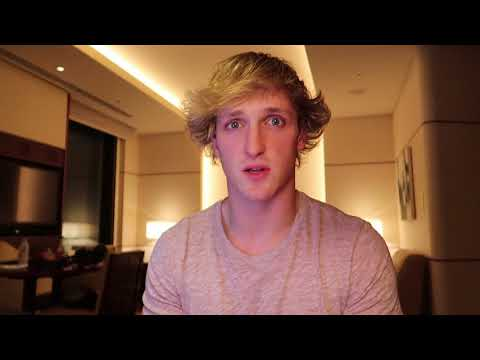

In [168]:
gb_vdo_topd = gb_vdo.sort_values(by = 'dislikes', ascending = False).reset_index()
print("Trending Video with highest Dislikes",gb_vdo_topd.iloc[0]["dislikes"],".")
YouTubeVideo(gb_vdo_topd.iloc[0]["video_id"])

Video with highest comments 1626501 .


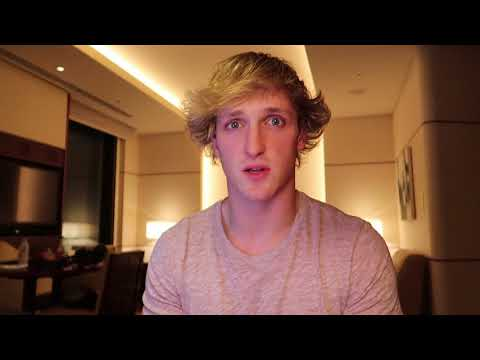

In [169]:
gb_vdo_topc = gb_vdo.sort_values(by = 'comment_count', ascending = False).reset_index()
print("Video with highest comments",gb_vdo_topc.iloc[0]["comment_count"],".")
YouTubeVideo(gb_vdo_topc.iloc[0]["video_id"])

**Okay. The trending video with highest dislikes has also topped the comments chart. People might not always appreciate if they like something, but are sure to say it loud if they dont like!!. Another point to note is, a video with highest likes may not be the video with highest views**

## 5. How many days for a video to be in trending list

**Next we will see how long a video can take, starting from the day it is published, to make it to the trending list**

In [171]:
#First we need to find the difference between the first date the video got into trening list and the publish date
gb_vdo_first = gb_vdo_df.sort_values(['trending_date'], ascending = True).groupby('video_id').first().reset_index()
gb_vdo_first['days4trend'] = (gb_vdo_first['trending_date'] - gb_vdo_first['publish_time'].dt.normalize()).dt.days

#Sort the records, by the number of days4trend.
gb_vdo_trends = gb_vdo_first.sort_values(by= 'days4trend', ascending = False)
gb_vdo_trends

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_id_d,days4trend
2971,tP_Dk81f9fg,2018-01-28,Jeffrey Lewis The Legend of The Fall,Dav hum,10,2007-03-05 16:23:55,"Jeffrey|""jack""|""Lewis""|""the""|""fall""",80158,333,2,24,https://i.ytimg.com/vi/tP_Dk81f9fg/default.jpg,False,False,False,Diaporama of Jeffrey Lewis low budget video ab...,Music,3982
2747,p9zTSvEpt_8,2018-01-25,Bill is Dead The Fall,georgegargan,10,2007-06-25 06:50:45,"the|""fall""|""Bill""|""is""|""dead""|""snub""|""tv""",81371,468,6,116,https://i.ytimg.com/vi/p9zTSvEpt_8/default.jpg,False,False,False,Bill Is Dead from Snub Tv by the mighty Fall,Music,3867
2885,rtQXLmkeOgo,2017-12-12,BBC TV Swap Shop Opening Titles & Clips,revoxy,27,2007-12-03 20:53:05,"BBC|""continuity""|""Noel""|""Edmonds""|""Keith""|""Che...",82854,112,4,43,https://i.ytimg.com/vi/rtQXLmkeOgo/default.jpg,False,False,False,Opening titles for later series with BBC conti...,Education,3662
1804,YJ1aeCE6pd4,2017-12-19,Fred Dibnah How to have a family holiday with ...,dovecott,22,2008-01-07 21:21:40,"Fred|""Dibnah""|""Scaffold""|""chimney""|""steam""|""bo...",43675,89,2,28,https://i.ytimg.com/vi/YJ1aeCE6pd4/default.jpg,False,False,False,Fred Dibnah takes Alison and the kids on holid...,People & Blogs,3634
2142,dqkEniTFTH0,2017-12-19,What Ever Happened to Baby Jane? - You're a Liar!,uhhuhhim,1,2008-08-29 23:19:07,"what|""ever""|""happened""|""to""|""baby""|""jane""|""bet...",159090,461,18,118,https://i.ytimg.com/vi/dqkEniTFTH0/default.jpg,False,False,False,"After Jane snaps, she brings Blanche her lunch...",Film & Animation,3399
2396,ip_r4y-23JM,2018-01-27,The Fall Hip Priest,P23BenBousquet,22,2008-12-19 18:03:01,"The|""Fall""|""Hip""|""Priest""",39524,239,2,44,https://i.ytimg.com/vi/ip_r4y-23JM/default.jpg,False,False,False,The Fall Hip Priest,People & Blogs,3326
0,--uXQQ0h-yQ,2017-12-25,Paul McCartney - Pipes of Peace,PonteFractus,24,2008-11-24 17:59:52,"ww1|""great""|""war""|""trenches""|""tommies""",24723,216,3,10,https://i.ytimg.com/vi/--uXQQ0h-yQ/default.jpg,False,False,False,Paul McCartney - Pipes of Peace,Entertainment,3318
2404,iwd9apG72IE,2018-01-16,Russ Abbot in Cooperman's Hotel,russabbotfan,23,2009-03-11 02:29:06,"Russ|""Abbot.""|""the""|""russ""|""abbot""|""show.""|""ma...",74942,148,7,39,https://i.ytimg.com/vi/iwd9apG72IE/default.jpg,False,False,False,Russ Abbot in Cooperman's Hotel. visit www.ru...,Comedy,3233
3074,w1fN1_9BNM8,2017-11-24,David Cassidy - White Christmas,catgil2,10,2009-11-29 13:59:59,"david|""cassidy""|""catgil2""|""shirley""|""jones""|""p...",47231,353,4,51,https://i.ytimg.com/vi/w1fN1_9BNM8/default.jpg,False,False,False,Merry Xmas!,Music,2917
1095,KtqVezaUhkA,2017-12-08,A Few Moments with Christine Keeler,roots66,24,2010-04-23 18:12:20,"Christine Keeler|""Profumo Affair""",52500,29,3,23,https://i.ytimg.com/vi/KtqVezaUhkA/default.jpg,False,False,False,Christine Keeler and someone dubbing her voice...,Entertainment,2786


In [172]:
# A video can make it to the trending list the day it is published.
#Now lets look at the maximum number of days a video had taken to make it to the trending list.
data = gb_vdo_trends.iloc[0]['days4trend']
print("Thats interesting!!! A video has taken ", data, "days to make it to the trending list")

Thats interesting!!! A video has taken  3982 days to make it to the trending list


**Thats like 10years and 9 months!!!!! And this is the video....**

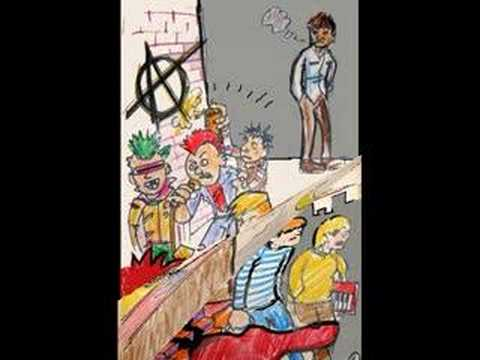

In [173]:
vdo_id=gb_vdo_trends.iloc[0]['video_id']
vdo_id
YouTubeVideo(vdo_id)

## 6. Category Prediction

**Let us look at if we can apply machine learning to predict the categories of the videos.**

In [174]:
##Lets take sample records for our analysis
vdo_dropna = gb_vdo_df.dropna()
sampled_videos = vdo_dropna.sample(100)
sampled_corpus = sampled_videos['description']


In [175]:

count_vectorizer = CountVectorizer(min_df=1)
term_freq_matrix = count_vectorizer.fit_transform(sampled_corpus)
tdm_df = pd.DataFrame(data=term_freq_matrix.toarray(), columns=count_vectorizer.get_feature_names())
tdm_df.head()


,000万部の国民的人気コミックが実写映画化,004,09xfdp,0dqve5p0hqnfdbe3ss8rkz,10,100,10014,1080p,10pm,11,...,합쳐져서,해주는,행보는,향하는,현재의,확인할,활동뿐만,후렴구의,후회하는,흥겨움을
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
count_vectorizer_stopped = CountVectorizer(min_df=1, stop_words=tm.stopwords)
term_freq_matrix_stopped = count_vectorizer_stopped.fit_transform(sampled_corpus)
tdm_stopped_df = pd.DataFrame(data=term_freq_matrix_stopped.toarray(), columns=count_vectorizer_stopped.get_feature_names())
tdm_stopped_df.head()

,000万部の国民的人気コミックが実写映画化,004,09xfdp,0dqve5p0hqnfdbe3ss8rkz,10,100,10014,1080p,10pm,11,...,합쳐져서,해주는,행보는,향하는,현재의,확인할,활동뿐만,후렴구의,후회하는,흥겨움을
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (tm.stem(w) for w in analyzer(doc))
count_vectorizer_stemmed = CountVectorizer(min_df=1, analyzer=stemmed_words)
term_freq_matrix_stemmed = count_vectorizer_stemmed.fit_transform(sampled_corpus)
tdm_stopped_stemmed_df = pd.DataFrame(data=term_freq_matrix_stemmed.toarray(), columns=count_vectorizer_stemmed.get_feature_names())
tdm_stopped_stemmed_df.head()

,000万部の国民的人気コミックが実写映画化,004,09xfdp,0dqve5p0hqnfdbe3ss8rkz,10,100,10014,1080p,10pm,11,...,합쳐져서,해주는,행보는,향하는,현재의,확인할,활동뿐만,후렴구의,후회하는,흥겨움을
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now create the TF-IDF matrix

In [178]:
def create_tfidf_matrix(tdm, features):
    transformer = TfidfTransformer()
    tf_idf_matrix = transformer.fit_transform(tdm)
    tfidf_df = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=features)
    return tfidf_df

tfidf_matrix = create_tfidf_matrix(term_freq_matrix, count_vectorizer.get_feature_names())
tfidf_matrix.head()

,000万部の国民的人気コミックが実写映画化,004,09xfdp,0dqve5p0hqnfdbe3ss8rkz,10,100,10014,1080p,10pm,11,...,합쳐져서,해주는,행보는,향하는,현재의,확인할,활동뿐만,후렴구의,후회하는,흥겨움을
0,0.0,0.0,0.0,0.0,0.038911,0.0,0.0,0.0,0.0,0.040546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
videos = gb_vdo_df.dropna(subset=["description","category_id_d"])

X_train, X_test, y_train, y_test = train_test_split(videos['description'], 
                                                    videos.category_id_d, random_state=0, test_size=0.5)
count_vectorizer = CountVectorizer(stop_words=None)
X_train_counts = count_vectorizer.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
model = LinearSVC()
classifier = model.fit(X_train_tfidf, y_train)

In [180]:
vec = count_vectorizer.transform(X_test)
predictions = classifier.predict(vec)
results = pd.DataFrame({
    "Video description": X_test,
    "Actual category": y_test,
    "Predicted category": predictions
})
results

,Video description,Actual category,Predicted category
8446,We talk to returning guest Bomani Jones about ...,Entertainment,Entertainment
4247,"Evan Spiegel, co-founder and CEO, explains the...",Music,Music
20910,Melania Trump appears to snub the president's ...,Entertainment,Entertainment
31958,Music video by Azealia Banks performing Anna W...,Music,Music
29119,Panic! At The Disco’s music video for ‘Say Ame...,Music,Music
20131,Check out this extended trailer and sneak peek...,Entertainment,Entertainment
25208,The Front Bottoms official video for their tra...,Music,Music
5134,i'm bhack🤑 BHAD BHABIE | Danielle Bregoli I G...,Music,Music
3985,Brazil's complicated history with electronics ...,Travel & Events,Travel & Events
1710,"Why do we love movies that are so bad, they're...",Education,Education


**The above table shows the predicted and actual categories. The accuracy score for the above can be calculated as below:*

In [181]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.9763758950504364

In [182]:
#Now lets look at for which videos the category prediction went wrong.
verify_res= results[results["Actual category"]!=results["Predicted category"]]
verify_res

,Video description,Actual category,Predicted category
36778,Blink-182 perform I Miss You on Jimmy Kimmel L...,Comedy,Entertainment
7312,"DAY 1515 // 27TH OCTOBER 2017 // Banana, Kirib...",People & Blogs,Howto & Style
15729,Buy my book - http://amzn.to/2nRy6tn\n\nI answ...,People & Blogs,Howto & Style
9955,ACCIDENTAL RING SHOPPING & PARTY TIME\n❄ Vlogm...,People & Blogs,Howto & Style
5660,The city of LA is trying to outlaw house parti...,People & Blogs,Sports
16066,When selling deodorant there is really only on...,Comedy,Entertainment
19989,What i wore and did at the BAFTAs 2018 with La...,People & Blogs,Howto & Style
11427,Meryl has been nominated for an Oscar TWENTY t...,Comedy,Entertainment
197,Get an unprecedented glimpse into Taylor's son...,Music,Entertainment
21389,A homeware haul and shopping in Notting Hill! ...,People & Blogs,Howto & Style


**There were 452 rows for  which prediction went wrong. I think some of the predicted and actual categories were closely related. For e.g:'Comedy'and 'Music' were predicted to be in 'Entertainment', 'People&Blogs' were predicted to be in 'Howto& Style', 'News&Politics'..etc..**